# Keras

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import load_model

plt.style.use('fivethirtyeight')
plt.rc('font', size=8)

## Загрузка и подготовка данных

Набор из 60 000 полутоновых изображений 28х28 серого цвета 10 категорий моды, а также тестовый набор из 10 000 изображений.

Классовые метки:
* 0 - футболка/клубка
* 1 - Брюки
* 2 - Пуловер
* 3 - Платье
* 4 - Пальто
* 5 - Сандал
* 6 - Рубашка
* 7 - Кроссовок
* 8 - Сумка
* 9 - Ботинок

In [2]:
MODEL_SAVE_PATH = './models/'
MODEL_NAME = 'fashion_mnist'

LABELS = ['футболка/клубка',
          'Брюки',
          'Пуловер',
          'Платье',
          'Пальто',
          'Сандал',
          'Рубашка',
          'Кроссовок',
          'Сумка',
          'Ботинок']

In [3]:
(X_train, y_train_labels), (X_test, y_test_labels) = fashion_mnist.load_data()

1 Брюки
(0, 255) (60000, 28, 28)


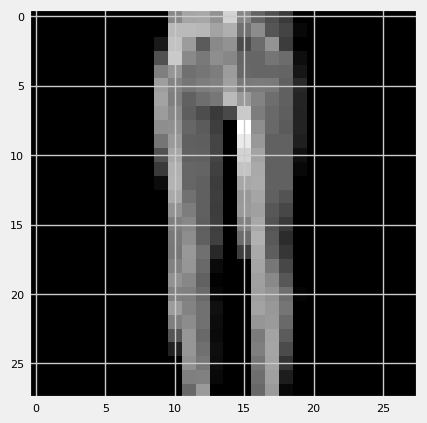

In [4]:
idx = np.random.randint(0, X_train.shape[0])
print(y_train_labels[idx], LABELS[y_train_labels[idx]])
print((X_train.min(), X_train.max()), X_train.shape)
plt.imshow(X_train[idx], cmap='gray')
plt.show()

In [5]:
X_train = X_train / 255.0
X_train = X_train.reshape(-1, 28 * 28)

X_test = X_test / 255.0
X_test = X_test.reshape(-1, 28 * 28)

print((X_train.min(), X_train.max()), X_train.shape)

(0.0, 1.0) (60000, 784)


In [6]:
y_train = to_categorical(y_train_labels)
y_test = to_categorical(y_test_labels)
print(y_train[0])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


## Анализ зависимости работы модели от гиперпараметров

### Число нейронов в слое

In [7]:
def plot_results(results, label):
    plt.figure(figsize=(14, 8))

    for result in results:
        for i, key in enumerate(['loss', 'val_loss', 'accuracy', 'val_accuracy']):
            plt.subplot(2, 2, i+1)
            plt.plot(result[key], label=f'{label}: {result[label]}')
            plt.title(key)
            plt.grid(True)
            plt.legend()

    plt.show()

In [8]:
def get_best_value(results, key):
    best_acc = 0
    best_value = None
    for result in results:
        if (best_acc < result['val_accuracy'][-1]):
            best_acc = result['val_accuracy'][-1]
            best_value = result[key]

    return best_value

In [9]:
results = []
for layer_size in range(100, 600, 100):
    model = Sequential([
        Dense(500, input_shape=(28 * 28,)),
        Dense(layer_size, activation='relu'),
        Dense(10, activation='sigmoid'),
    ])
    model.compile(
        loss='categorical_crossentropy',
        optimizer='SGD',
        metrics=['accuracy']
    )
    
    history = model.fit(X_train, y_train,
                        epochs=7,
                        batch_size=64,
                        verbose=0,
                        validation_data=(X_test, y_test))

    results.append({'layer_size': layer_size,
                    'loss': history.history['loss'],
                    'val_loss': history.history['val_loss'],
                    'accuracy': history.history['accuracy'],
                    'val_accuracy': history.history['val_accuracy']})


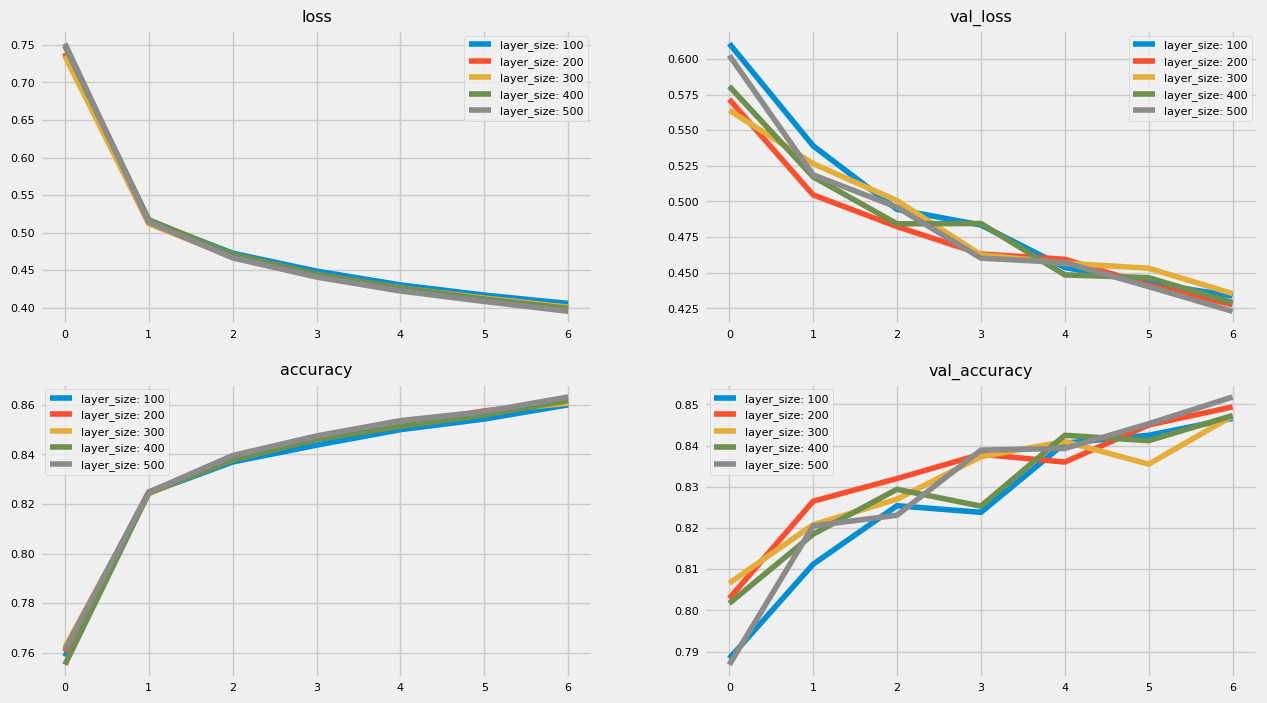

best_layer_size: 500


In [10]:
plot_results(results, 'layer_size')
best_layer_size = get_best_value(results, 'layer_size')
print(f'best_layer_size: {best_layer_size}')

### Количество скрытых слоев

In [11]:
results = []
for layer_count in [2, 3, 5, 10]:
    model = Sequential()
    model.add(Dense(500, input_shape=(28 * 28,)))
    
    for _ in range(layer_count):
        layer_size = best_layer_size // layer_count
        model.add(Dense(layer_size, activation='relu'))

    model.add(Dense(10, activation='sigmoid'))

    model.compile(
        loss='categorical_crossentropy',
        optimizer='SGD',
        metrics=['accuracy']
    )

    history = model.fit(X_train, y_train,
                        epochs=7,
                        batch_size=64,
                        verbose=0,
                        validation_data=(X_test, y_test))

    results.append({'layer_count': layer_count,
                    'loss': history.history['loss'],
                    'val_loss': history.history['val_loss'],
                    'accuracy': history.history['accuracy'],
                    'val_accuracy': history.history['val_accuracy']})

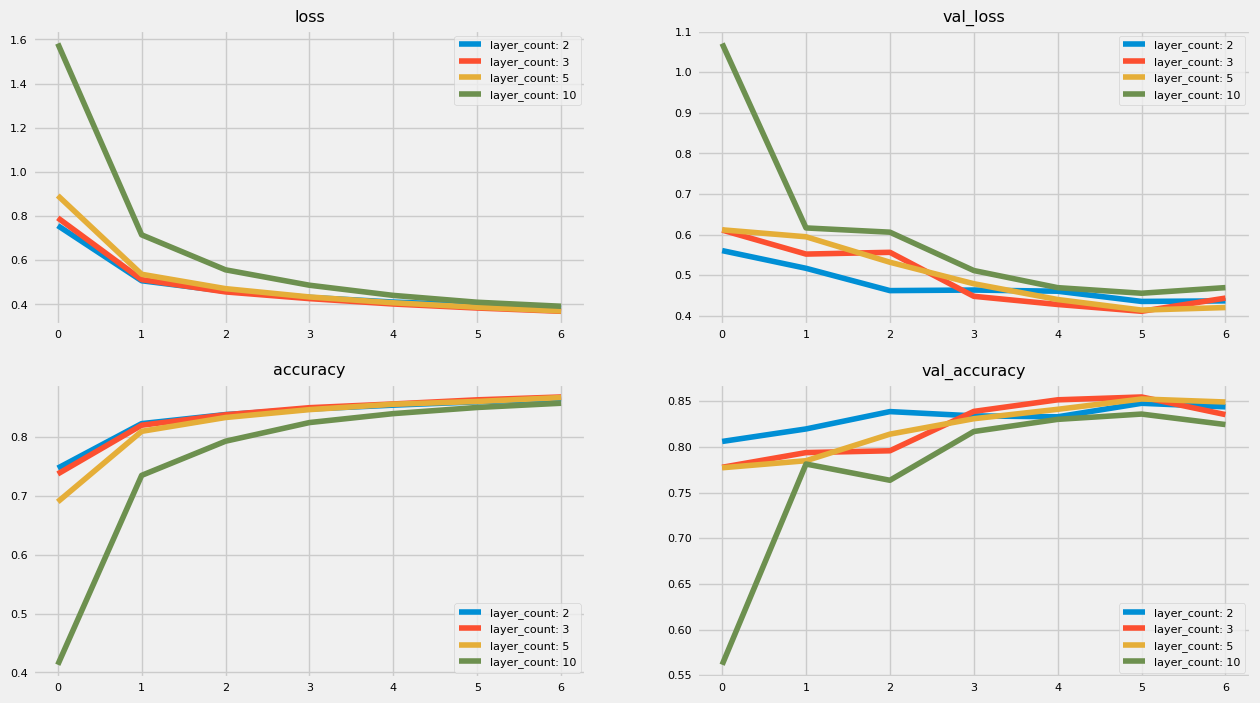

best_layer_count: 5


In [12]:
plot_results(results, 'layer_count')
best_layer_count = get_best_value(results, 'layer_count')
print(f'best_layer_count: {best_layer_count}')

### Оптимизатор

In [13]:
results = []
for optimizer in ['SGD', 'Adam', 'RMSProp']:
    model = Sequential()
    model.add(Dense(500, input_shape=(28 * 28,)))
    
    for _ in range(best_layer_count):
        layer_size = best_layer_size // best_layer_count
        model.add(Dense(layer_size, activation='relu'))

    model.add(Dense(10, activation='sigmoid'))

    model.compile(
        loss='categorical_crossentropy',
        optimizer=optimizer,
        metrics=['accuracy']
    )

    history = model.fit(X_train, y_train,
                        epochs=7,
                        batch_size=64,
                        verbose=0,
                        validation_data=(X_test, y_test))

    results.append({'optimizer': optimizer,
                    'loss': history.history['loss'],
                    'val_loss': history.history['val_loss'],
                    'accuracy': history.history['accuracy'],
                    'val_accuracy': history.history['val_accuracy']})

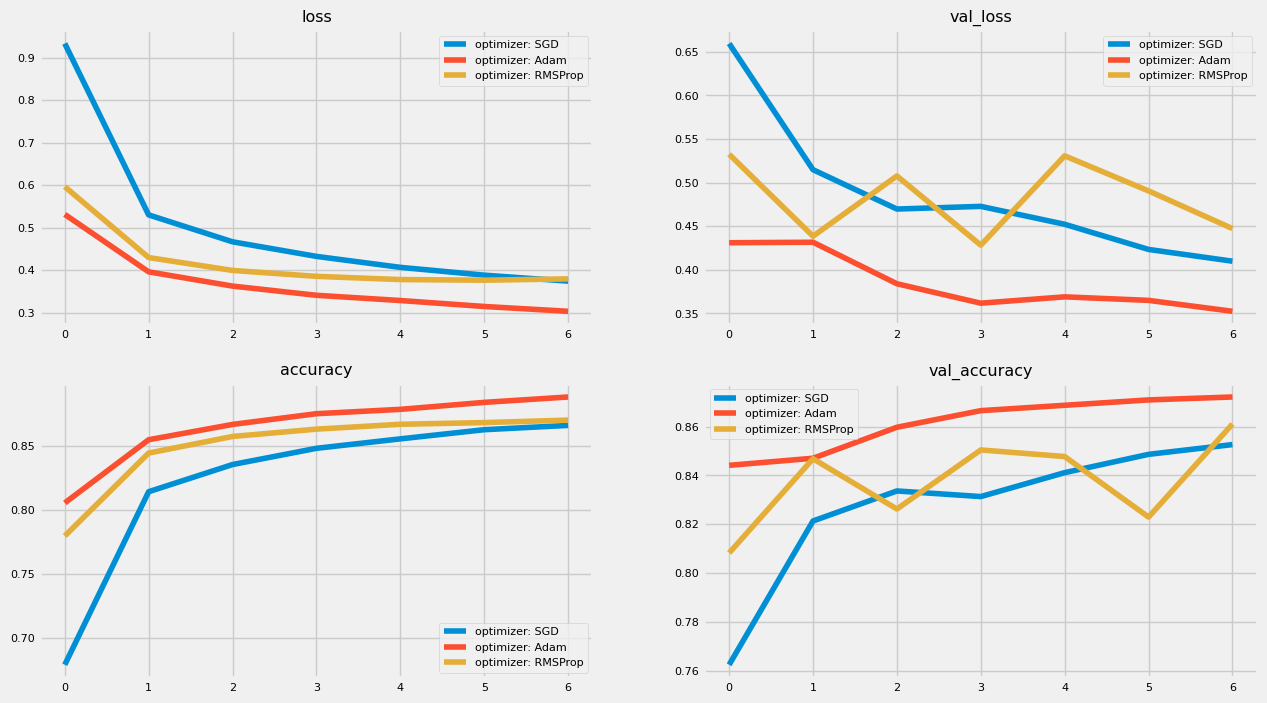

best_optimizer: Adam


In [14]:
plot_results(results, 'optimizer')
best_optimizer = get_best_value(results, 'optimizer')
print(f'best_optimizer: {best_optimizer}')

### Лучшая модель

In [15]:
from tensorflow.keras.callbacks import Callback

In [16]:
class OnEpochEnd(Callback):
    def __init__(self):
        super().__init__()
        self.best_acc = 0
        self.best_epoch = 0
        self.save_path = MODEL_SAVE_PATH + MODEL_NAME + '_best.h5'

    def on_epoch_end(self, epoch, logs=None):
        if self.best_acc < logs['val_accuracy']:
            self.best_acc = logs['val_accuracy']
            self.best_epoch = epoch
            self.model.save(self.save_path)

            print(f'Epoch {epoch+1}:')
            print(f'\tModel with best accuracy saved to {self.save_path}')
            print(f'\tval_accuracy: {logs["val_accuracy"]}\n')

In [17]:
callback = OnEpochEnd()

model = Sequential()
model.add(Dense(500, input_shape=(28 * 28,)))
for _ in range(best_layer_count):
    layer_size = best_layer_size // best_layer_count
    model.add(Dense(layer_size, activation='relu'))

model.add(Dense(10, activation='sigmoid'))

model.compile(
    loss='categorical_crossentropy',
    optimizer=best_optimizer,
    metrics=['accuracy']
)

history = model.fit(X_train, y_train,
                    epochs=20,
                    batch_size=64,
                    verbose=0,
                    validation_data=(X_test, y_test),
                    callbacks=[callback,])

Epoch 1:
	Model with best accuracy saved to ./models/fashion_mnist_best.h5
	val_accuracy: 0.8356999754905701

Epoch 2:
	Model with best accuracy saved to ./models/fashion_mnist_best.h5
	val_accuracy: 0.8361999988555908

Epoch 3:
	Model with best accuracy saved to ./models/fashion_mnist_best.h5
	val_accuracy: 0.8562999963760376

Epoch 4:
	Model with best accuracy saved to ./models/fashion_mnist_best.h5
	val_accuracy: 0.8604000210762024

Epoch 6:
	Model with best accuracy saved to ./models/fashion_mnist_best.h5
	val_accuracy: 0.8758000135421753

Epoch 16:
	Model with best accuracy saved to ./models/fashion_mnist_best.h5
	val_accuracy: 0.8801000118255615

Epoch 17:
	Model with best accuracy saved to ./models/fashion_mnist_best.h5
	val_accuracy: 0.8804000020027161

Epoch 18:
	Model with best accuracy saved to ./models/fashion_mnist_best.h5
	val_accuracy: 0.8812000155448914

Epoch 19:
	Model with best accuracy saved to ./models/fashion_mnist_best.h5
	val_accuracy: 0.8820000290870667

Epoch 

Параметры лучшей модели:
	Оптимизатор: Adam
	Количество скрытых слоев: 5
	Размер слоя: 100
	Эпоха: 20
	val_accuracy: 0.882099986076355


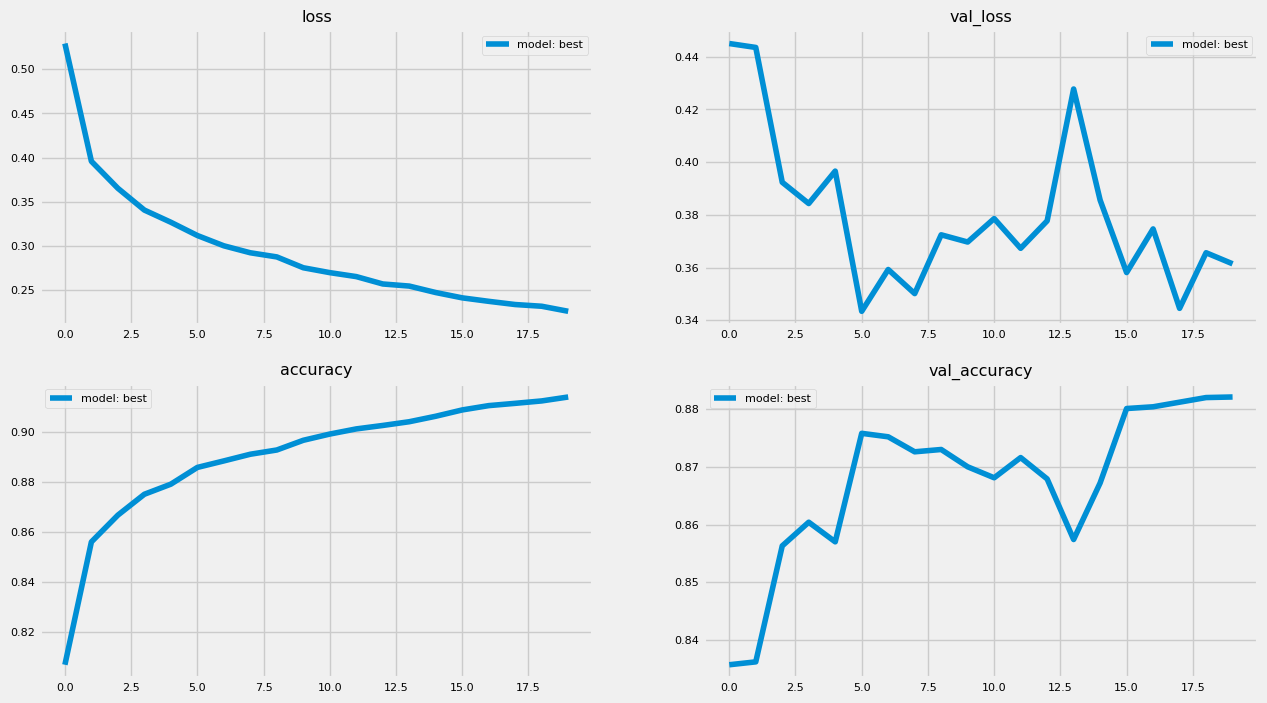

In [18]:
results = [{'model': 'best',
            'loss': history.history['loss'],
            'val_loss': history.history['val_loss'],
            'accuracy': history.history['accuracy'],
            'val_accuracy': history.history['val_accuracy']},]

print(f'Параметры лучшей модели:')
print(f'\tОптимизатор: {best_optimizer}')
print(f'\tКоличество скрытых слоев: {best_layer_count}')
print(f'\tРазмер слоя: {best_layer_size // best_layer_count}')
print(f'\tЭпоха: {callback.best_epoch+1}')
print(f'\tval_accuracy: {callback.best_acc}')
plot_results(results, 'model')

In [19]:
best_model = load_model(callback.save_path)
pred = best_model.predict(X_test)

313/313 [==============================] - 0s 1ms/step


Реальное значение: Пуловер
Предсказанное значение: Пуловер


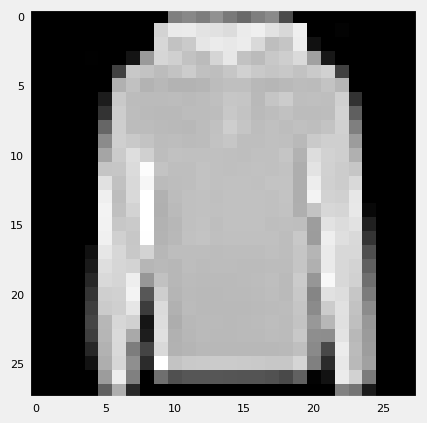

In [20]:
idx = np.random.randint(0, X_test.shape[0])
print(f'Реальное значение: {LABELS[y_test[idx].argmax()]}')
print(f'Предсказанное значение: {LABELS[pred[idx].argmax()]}')

plt.imshow(X_test[idx].reshape((28,28)), cmap='gray')
plt.grid(False)
plt.show()